* What insights can we gain from exploring and visualizing our data?
* How does sentiment play into rating and usefulness of reviews?
* Can we create a way for people to find the best medication for their illness?
* What machine learning models work best for predicting the sentiment or rating based on review?
* Can we somehow find insight into what features or words are most important for predicting review rating?

# Drug Ratings Dataset: Preliminary Data Exploration

<br>
ideas for exploration:
- Most common conditions
- Overall best and worst reviewed drugs
- The curability of each disease
- Best drugs for each condition
- Most useful reviews
- Usefulness vs review score
- Bias in reviews
    - Users tend to review things they really liked or really disliked, fewer reviews in the middle


In [1]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Create dataframes train and test
train = pd.read_csv('input/drugsComTrain_raw.csv')
test = pd.read_csv('input/drugsComTest_raw.csv')

In [3]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
list(train) == list(test)

True

Both train and test have the same features. Maybe they are split up to allow us to train/test our models easily.

In [6]:
list(train)

['uniqueID',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [7]:
train.values.shape[0], test.values.shape[0], train.values.shape[0] / test.values.shape[0]

(161297, 53766, 2.999981400885318)

Yep, the train set is almost exactly 3 times as big as the test set! This is a typical 75:25 train:test split.

In [8]:
train.condition.unique().size, test.condition.unique().size

(885, 709)

In [9]:
train.drugName.unique().size, test.drugName.unique().size

(3436, 2637)

## Common Conditions

In [10]:
# I previously did this by creating and sorting a dictionary -- here's an easier way with pandas! (Inspiration from Sayan Goswami)
conditions = train.condition.value_counts().sort_values(ascending=False)
conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]

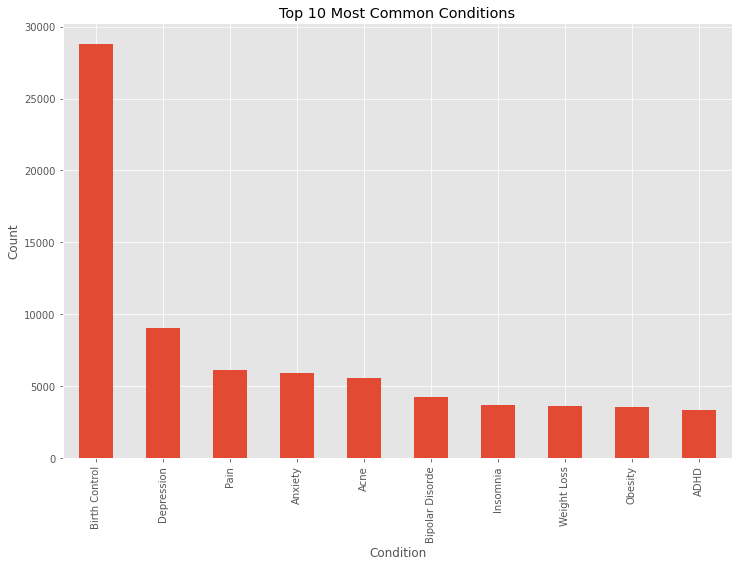

In [12]:
conditions[:10].plot(kind='bar')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

We're familiar with these most common conditions. It makes sense that something like birth control would have more reviews than something like anthrax! (Presumably, anthrax antibiotics?)

## Rating Distribution

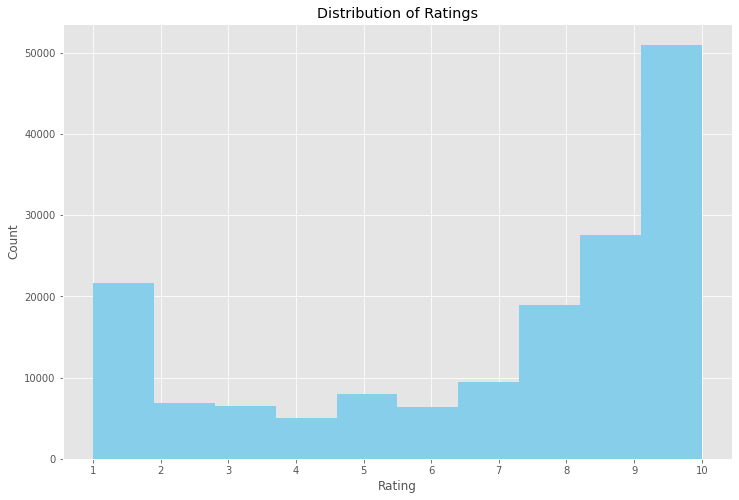

In [13]:
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
train.rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);

This distribution illustrates that people generally write reviews for drugs they really like (or those that they really dislike). There are fewer middle ratings as compared to extreme ratings. 

Text(0, 0.5, 'Count')

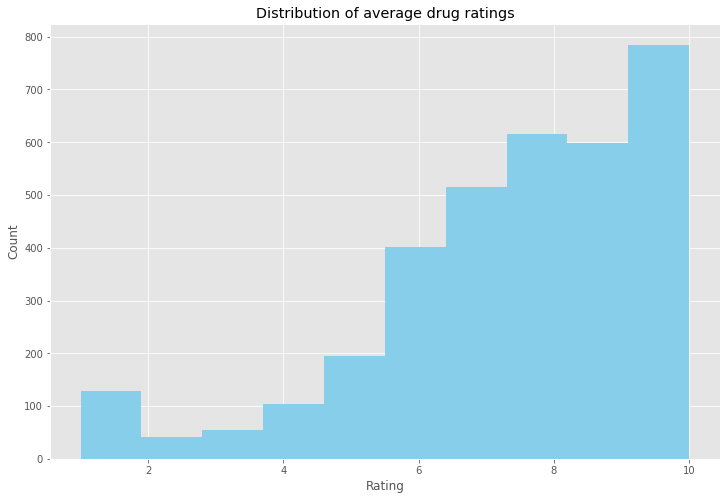

In [14]:
rating_avgs = (train['rating'].groupby(train['drugName']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Distribution of average drug ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

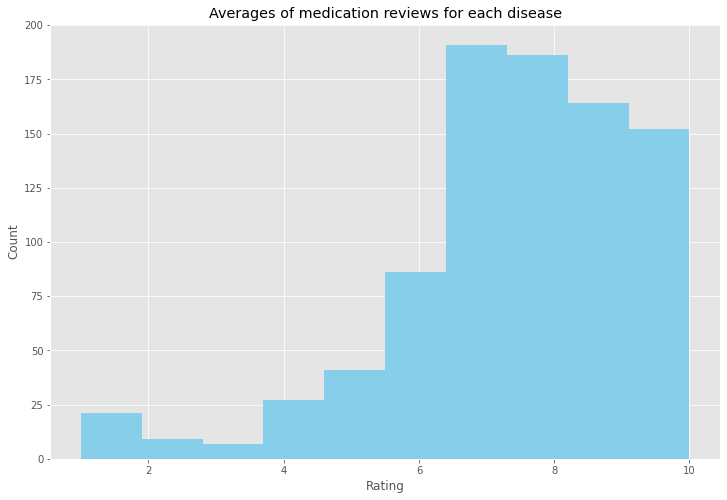

In [15]:
rating_avgs = (train['rating'].groupby(train['condition']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Averages of medication reviews for each disease')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Usefulness vs Rating

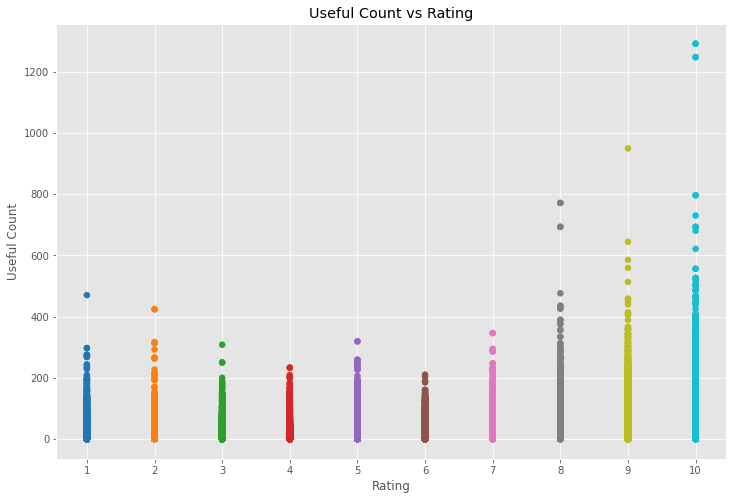

In [16]:
# Is rating correlated with usefulness of the review?
plt.scatter(train.rating, train.usefulCount, c=train.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

In [17]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(train[train.rating == i].usefulCount) / np.sum([train.rating == i])])
    
use_arr = np.asarray(use_ls)

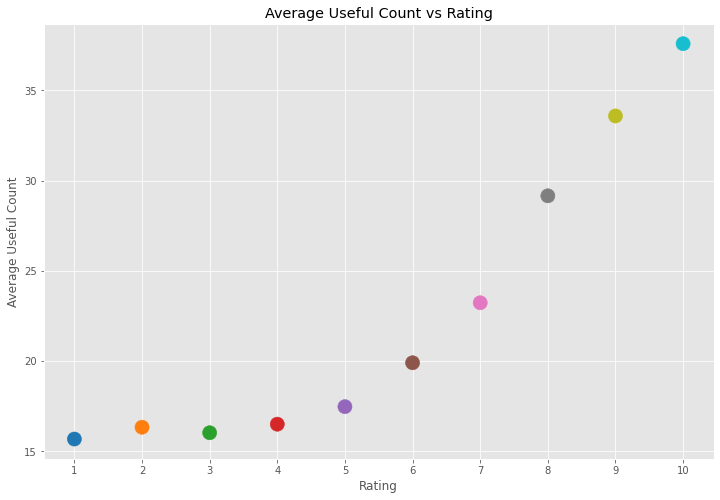

In [18]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);

Looks like people found reviews with higher scores to be more useful! In the sense that reviews with high ratings recieved more 'useful' tags than reviews with low ratings. Interesting...

In [19]:
# Sort train dataframe from most to least useful
useful_train = train.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:10]

,uniqueID,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
152838,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730


In [20]:
# Print top 10 most useful reviews
for i in useful_train.review.iloc[:3]:
    print(i, '\n')

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

The useful reviews seem positive! Let's see some not-so-useful reviews:

In [21]:
# Print 10 of the least useful reviews
for i in useful_train.review.iloc[-3:]:
    print(i, '\n')

"I received Implanon in May of 2008. I am due to have it removed in 6 months however, for the past year I have experienced decrease in sex drive, weight gain of 30lbs and also mood swings. My periods have been very scheduled and fairly regular which was great until 4-5 months ago when I missed a period then was on time the following 2 months. Last month I started a week early and it was unusually light, this month I started 2 1/2 weeks early and it has been off and on spotting for the past 5 days. I did call the helpline when I missed my period. They did not seem to concerned and I have not been able to find ANYwhere the birth rates on this specific birth control! I loved it until a year ago so the first half of my experience was great the last half no." 

"The only warning my gyno gave me was that I would be spotting for about 15 days after having the IUD inserted, which was a damn lie.  I spotted for a whole four weeks after the procedure.  My uterus chilled for two weeks before I st

The not-so-useful reviews seem much more negative. The final review listed is barely a review -- just a concerned patient asking questions about the product!

Our conclusions appear consistent with the above graph -- reviewers find higher ratings/better reviews to be more useful than lower ratings/worse reviews. Does this represent some sort of bias within the useful count?

We're also interested in quantifying the sentiment of these reviews.

In [22]:
sid = SentimentIntensityAnalyzer()

In [23]:
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in train.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

In [24]:
sentiments

array([-0.296 ,  0.8603,  0.7962, ..., -0.743 ,  0.6197,  0.6124])

In [25]:
useful_train['sentiment'] = pd.Series(data=sentiments)

In [26]:
useful_train = useful_train.reset_index(drop=True)
useful_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
1,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
2,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
3,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
4,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949,-0.6815


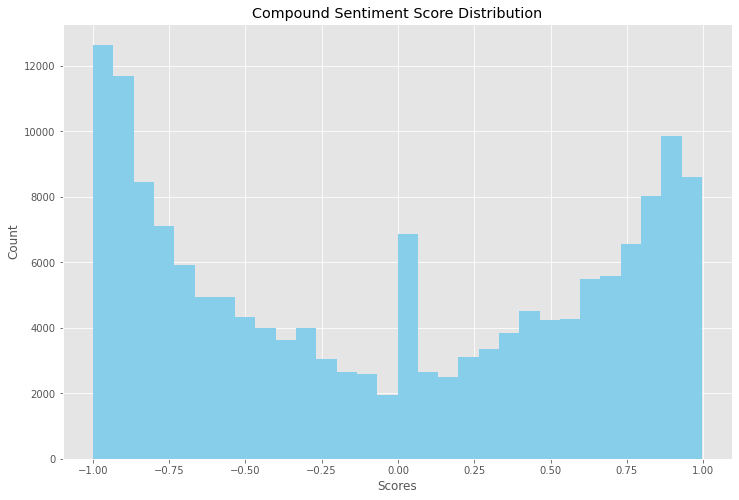

In [27]:
useful_train.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

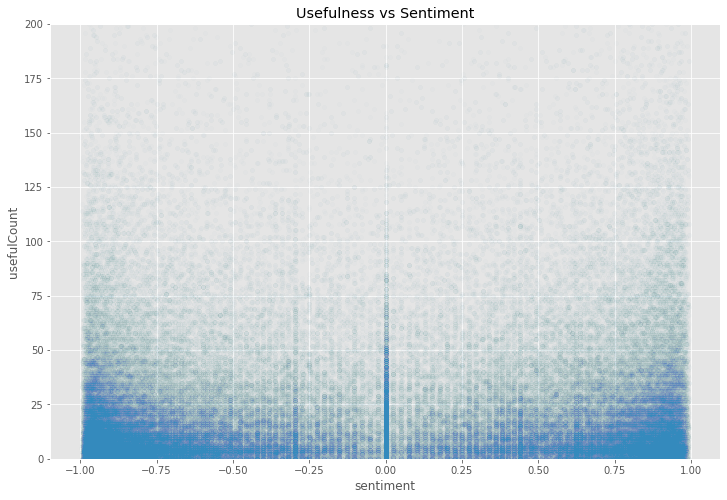

In [28]:
useful_train.plot(x='sentiment', y='usefulCount', kind='scatter', alpha=0.01)
plt.title('Usefulness vs Sentiment')
plt.ylim(0, 200);

In [29]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiment) / np.sum(useful_train.rating == i))

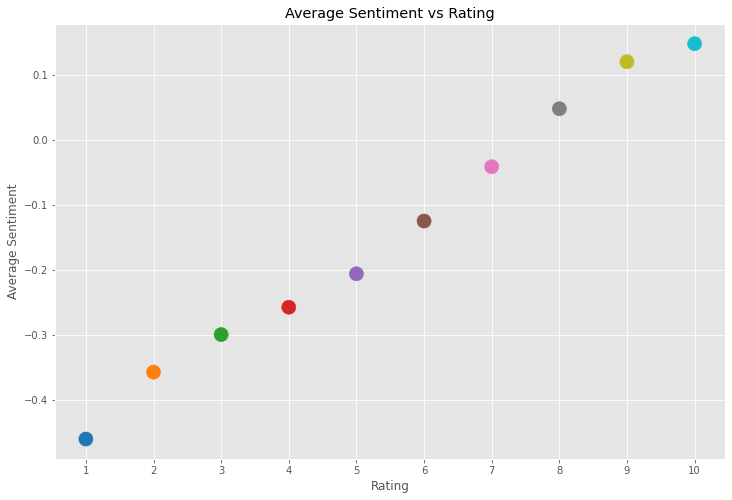

In [30]:
plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)]);

Let's see what other meaningful insights we can get from the data! Find the best and worst reviewed drugs overall:

In [31]:
# Create a list of all drugs and their average ratings, cast to dataframe
rate_ls = []

for i in train.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(train.drugName == i) >= 10:
        rate_ls.append((i, np.sum(train[train.drugName == i].rating) / np.sum(train.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)

In [32]:
# Sort drugs by their ratings, look at top 10 best and worst rated drugs
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Zutripro,10.000000
1,Chlorpheniramine / hydrocodone / pseudoephedrine,10.000000
2,Silver sulfadiazine,9.972222
3,Drixoral Cold and Allergy,9.948718
4,Dexbrompheniramine / pseudoephedrine,9.947368
5,Emend,9.900000
6,Aprepitant,9.900000
7,Tegaserod,9.812500
8,Zelnorm,9.687500
9,Cyanocobalamin,9.666667


In [33]:
avg_rate[-10:]

,0,1
1371,Prevnar 13,3.363636
1372,Fosamax,3.166667
1373,Blisovi 24 Fe,3.088889
1374,Opdivo,3.083333
1375,Miconazole,3.033000
1376,Monistat 7,3.032258
1377,Alendronate,2.954545
1378,Yuvafem,2.318182
1379,Monistat 1-Day or Night Combination Pack,1.416667
1380,ProAir RespiClick,1.193548


A quick Google search seems to confirms our results!

## Best and Worst Drugs by Condition
<br>
Let's find the highest and lowest rated drugs for each condition! This information will be helpful for a user who is looking for medication for a specific condition.

In [34]:
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
help_dict = {}

# Iterate over conditions
for i in train.condition.unique():
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in train[train.condition == i].drugName.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average rating in temporary list
        if np.sum(train.drugName == j) >= 10:
            temp_ls.append((j, np.sum(train[train.drugName == j].rating) / np.sum(train.drugName == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    help_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)

Now we've got a very useful 'help_dict' dictionary! 

We can simply index the dictionary by a specific condition to see the top rated drugs for that condition. For example, let's look at the top 10 drugs for birth control:

In [35]:
help_dict['Birth Control'].iloc[:10]

,drug,average_rating
0,Plan B,8.674917
1,Lybrel,7.600000
2,Ortho Evra,7.470320
3,Kyleena,7.463576
4,Levonorgestrel,7.391031
5,Ortho-Cept,7.250000
6,Skyla,7.246359
7,Copper,7.235197
8,Beyaz,7.042553
9,Dienogest / estradiol,6.875000


Drugs used for birth control are listed, from best to worst average rating. Let's the top 10 best drugs for some other conditions:

In [36]:
help_dict['Depression'].iloc[:10]

,drug,average_rating
0,Desipramine,9.285714
1,Xanax XR,8.947368
2,Alprazolam,8.933144
3,Xanax,8.881579
4,Parnate,8.763158
5,St. john's wort,8.739130
6,Nefazodone,8.727273
7,Methylin ER,8.700000
8,Clomipramine,8.680000
9,Phenelzine,8.666667
